In [1]:
from sympy.printing.pytorch import torch

"""import scanpy as sc

glutamatergic = sc.read("processed_files/glutamatergic.h5ad")
glutamatergic = glutamatergic[glutamatergic.obs["disease"] == "Alzheimer disease"]

sc.pp.highly_variable_genes(glutamatergic, n_top_genes=3000, subset=True)

glutamatergic.write("processed_files/glutamatergic_als_highly_var.h5ad")"""

In [1]:
import scanpy as sc
adata = sc.read("processed_files/glutamatergic_als_highly_var.h5ad")

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


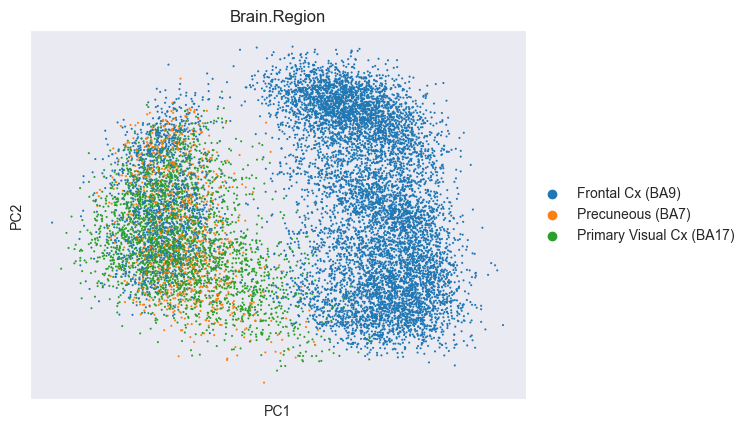

In [18]:
eg_subject = adata[adata.obs["donor_id"] == "35"]

sc.pp.pca(eg_subject, n_comps=2)
sc.pl.pca(eg_subject, color="Brain.Region")

In [29]:
import numpy as np
from sklearn.neighbors import KernelDensity

# 2D PCA
PCA = eg_subject.obsm["X_pca"][:, :2]

# Fit KDE
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(PCA)

# Create a 2D grid
x = np.linspace(PCA[:,0].min(), PCA[:,0].max(), 100)
y = np.linspace(PCA[:,1].min(), PCA[:,1].max(), 100)
X, Y = np.meshgrid(x, y)
grid = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate density
log_density = kde.score_samples(grid)
Z = np.exp(log_density).reshape(X.shape)  # z-axis = density

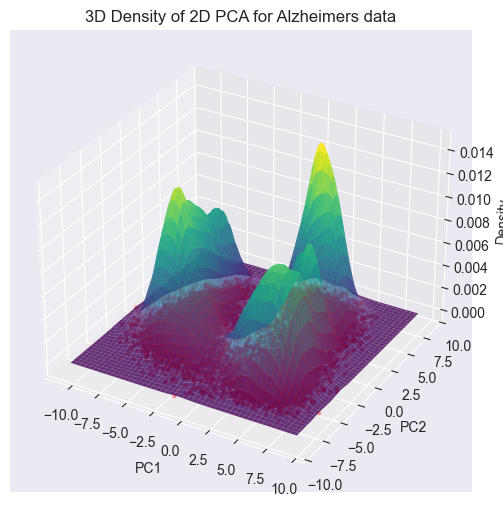

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Optional: overlay points
ax.scatter(PCA[:,0], PCA[:,1], np.zeros(PCA.shape[0]), c='red', s=5, alpha=0.3)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Density')
ax.set_title('3D Density of 2D PCA for Alzheimers data')
plt.show()

In [61]:
data = eg_subject.X
data = torch.tensor(data.toarray())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

# -----------------------------
# Affine Coupling Layer (RealNVP style)
# -----------------------------
class AffineCoupling(nn.Module):
    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.dim = dim
        self.mask = mask
        self.scale_net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, dim), nn.Tanh()
        )
        self.trans_net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.trans_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det = torch.sum(s, dim=1)
        return y, log_det

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.trans_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det = -torch.sum(s, dim=1)
        return x, log_det

# -----------------------------
# Normalizing Flow Model
# -----------------------------
class NormalizingFlow(nn.Module):
    def __init__(self, dim, hidden_dim, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            mask = self._create_mask(dim, even=(i % 2 == 0))
            self.layers.append(AffineCoupling(dim, hidden_dim, mask))

    def _create_mask(self, dim, even=True):
        mask = torch.zeros(dim)
        mask[::2] = 1 if even else 0
        mask[1::2] = 0 if even else 1
        return mask

    def forward(self, x):
        log_det_sum = 0
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_sum += log_det
        return x, log_det_sum

    def inverse(self, z):
        log_det_sum = 0
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z)
            log_det_sum += log_det
        return z, log_det_sum

if __name__ == "__main__":
    torch.manual_seed(0)

    # Synthetic 8D Gaussian mixture dataset

    dim = 3000
    hidden_dim = 5196
    n_layers = 12

    flow = NormalizingFlow(dim, hidden_dim, n_layers)
    optimizer = torch.optim.Adam(flow.parameters(), lr=3e-6)

    base = torch.distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

    n_epochs = 150
    batch_size = 2096

    for epoch in range(0, n_epochs + 1):
        perm = torch.randperm(data.shape[0])
        total_loss = 0
        for i in range(0, data.shape[0], batch_size):
            batch = data[perm[i:i+batch_size]]
            z, log_det = flow(batch)
            log_prob = base.log_prob(z) + log_det
            loss = -log_prob.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(batch)

        avg_loss = total_loss / data.shape[0]
        print(f"Epoch {epoch:02d} | Loss {avg_loss:.4f}")

In [81]:
import torch
import numpy as np
from sklearn.decomposition import PCA

# Original data
original_data = data.detach().numpy()  # convert to NumPy if necessary

# Sample from flow
n_samples_plot = 500
z_sample = base.sample((n_samples_plot,))
flow_sample, _ = flow.inverse(z_sample)
flow_sample = flow_sample.detach().numpy()

# Combine for PCA
combined = np.vstack([original_data, flow_sample])
pca = PCA(n_components=2)
combined_2d = pca.fit_transform(combined)

# Split back
original_2d = combined_2d[:original_data.shape[0]]
flow_2d = combined_2d[original_data.shape[0]:]


In [82]:
from sklearn.neighbors import KernelDensity

def compute_kde_2d(points, grid_size=100, bandwidth=0.3):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(points)

    x_min, y_min = points.min(axis=0)
    x_max, y_max = points.max(axis=0)
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    X, Y = np.meshgrid(x, y)

    grid = np.vstack([X.ravel(), Y.ravel()]).T
    log_density = kde.score_samples(grid)
    Z = np.exp(log_density).reshape(grid_size, grid_size)

    return X, Y, Z

In [83]:
X_orig, Y_orig, Z_orig = compute_kde_2d(original_2d)
X_flow, Y_flow, Z_flow = compute_kde_2d(flow_2d)

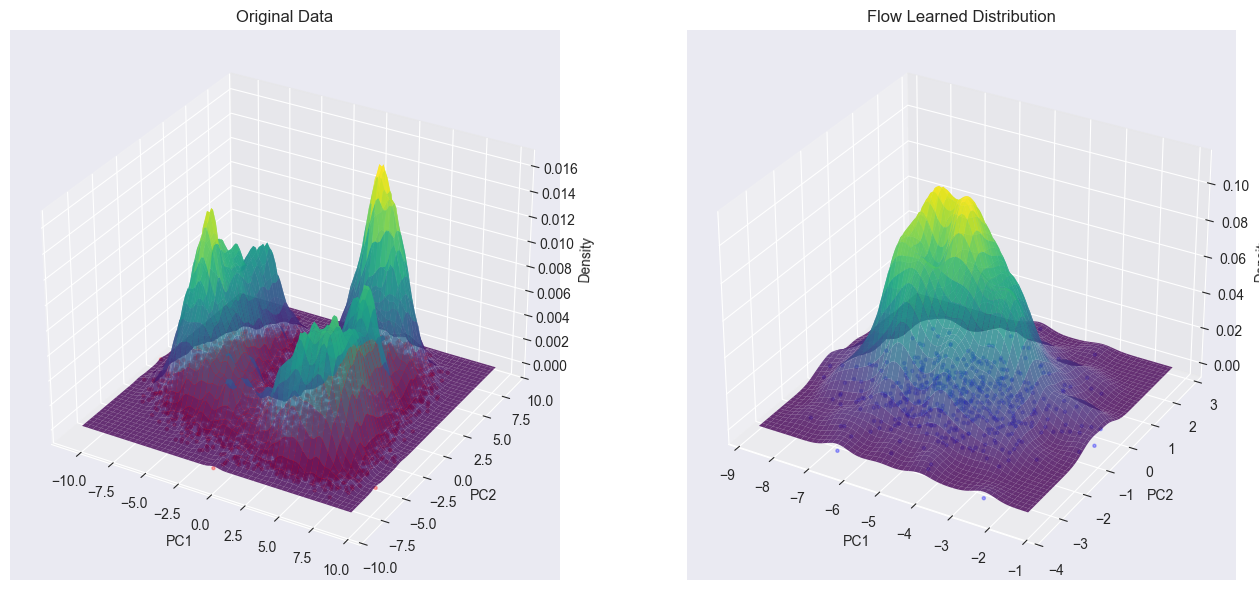

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,6))

# Original data
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_orig, Y_orig, Z_orig, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.scatter(original_2d[:,0], original_2d[:,1], np.zeros(original_2d.shape[0]),
            c='red', s=5, alpha=0.3)
ax1.set_title('Original Data')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('Density')

# Flow-generated data
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X_flow, Y_flow, Z_flow, cmap='viridis', edgecolor='none', alpha=0.8)
ax2.scatter(flow_2d[:,0], flow_2d[:,1], np.zeros(flow_2d.shape[0]),
            c='blue', s=5, alpha=0.3)
ax2.set_title('Flow Learned Distribution')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('Density')

plt.tight_layout()
plt.show()